#Modelo3 - Ventas por Categoria

Este modelo busca predecir la ventas que se realizaran de acuerdo a la categoria elegida.

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [116]:
df = pd.read_csv('categorias_vendidas.csv', parse_dates=['fecha'])

In [117]:
# Mostrar primeras filas y estadísticas descriptivas
print("--- Primeras filas ---")
print(df.head())
print("\n--- Estadísticas descriptivas ---")
df.describe()

--- Primeras filas ---
       fecha  categoria  total
0 2024-04-01          5  594.0
1 2024-04-01          4  207.0
2 2024-04-01          5  396.0
3 2024-04-01          3   96.0
4 2024-04-01          4   80.0

--- Estadísticas descriptivas ---


,fecha,categoria,total
count,136183,136183.000000,136183.000000
mean,2024-11-29 02:42:03.433909248,5.301007,178.479987
min,2024-04-01 00:00:00,1.000000,0.000000
25%,2024-08-22 00:00:00,2.000000,49.000000
50%,2024-12-09 00:00:00,4.000000,86.000000
75%,2025-03-08 00:00:00,10.000000,156.000000
max,2025-05-31 00:00:00,12.000000,95036.000000
std,NaN,3.642733,672.560124


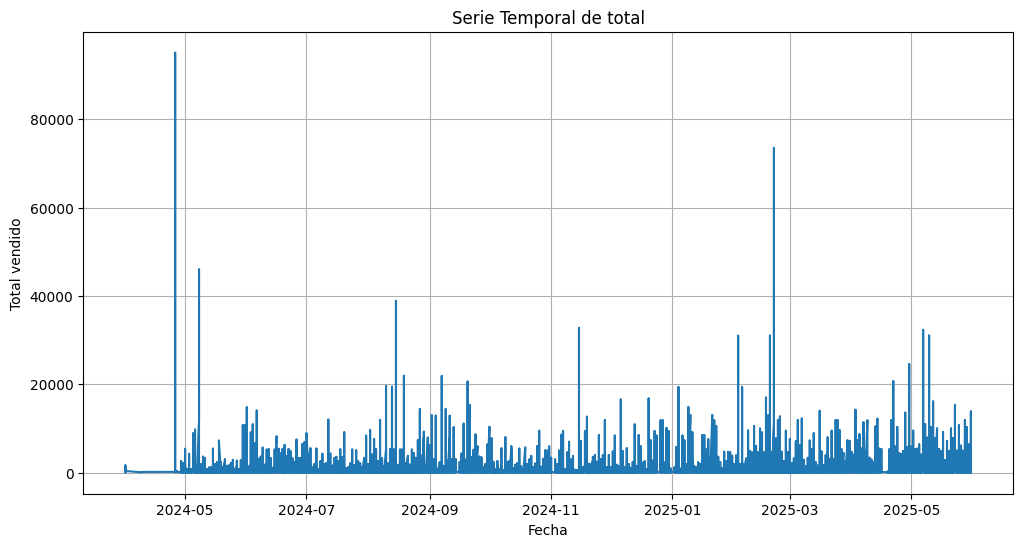

In [118]:
# Visualización de la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(df['fecha'], df['total'])
plt.title('Serie Temporal de total')
plt.xlabel('Fecha')
plt.ylabel('Total vendido')
plt.grid()
plt.show()

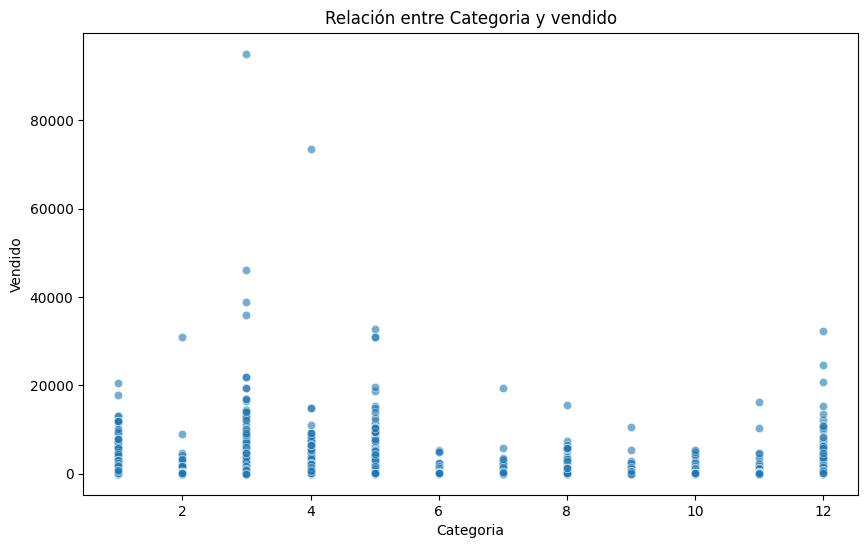

In [119]:
# Gráfico de dispersión (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="categoria", y="total", alpha=0.6)
plt.title("Relación entre Categoria y vendido")
plt.xlabel("Categoria")
plt.ylabel("Vendido")
plt.show()


--- Anomalías detectadas (usando IQR) ---
            fecha  categoria   total
0      2024-04-01          5   594.0
2      2024-04-01          5   396.0
16     2024-04-01          5  1100.0
17     2024-04-01          5  1650.0
18     2024-04-01          3   760.0
...           ...        ...     ...
136175 2025-05-31          1   490.0
136176 2025-05-31          8  1250.0
136177 2025-05-31          8  1375.0
136181 2025-05-31          1   540.0
136182 2025-05-31          1   884.0

[11328 rows x 3 columns]

--- DataFrame después de filtrar anomalías ---
       fecha  categoria  total
1 2024-04-01          4  207.0
3 2024-04-01          3   96.0
4 2024-04-01          4   80.0
5 2024-04-01          1   35.0
6 2024-04-01          4  140.0


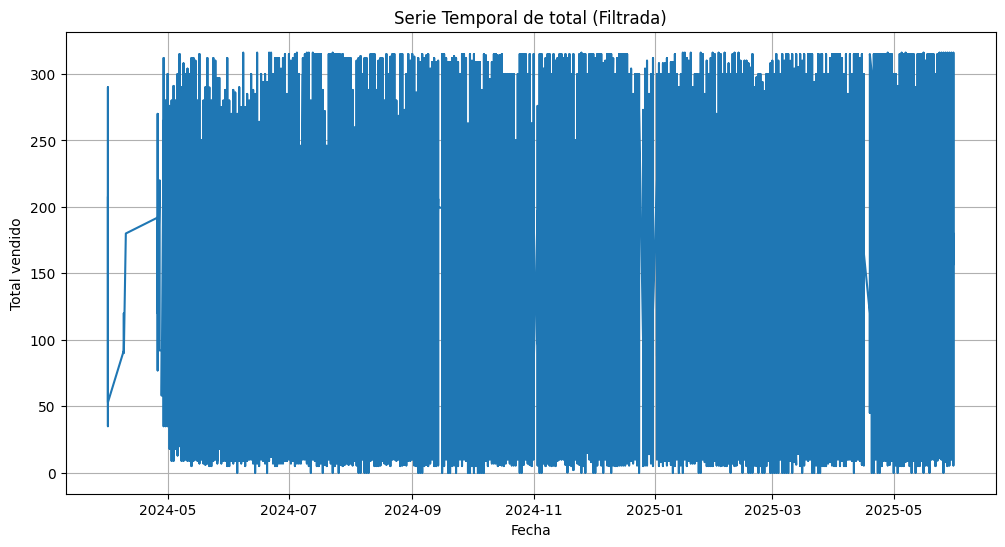

In [120]:
# prompt: aplicar filtrado de anomalias

# Aplicar un enfoque simple de detección de anomalías (por ejemplo, umbral basado en IQR)
Q1 = df['total'].quantile(0.25)
Q3 = df['total'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Identificar y eliminar anomalías
anomalies = df[(df['total'] < lower_bound) | (df['total'] > upper_bound)]
print("\n--- Anomalías detectadas (usando IQR) ---")
print(anomalies)
df_filtered = df[(df['total'] >= lower_bound) & (df['total'] <= upper_bound)].copy()
print("\n--- DataFrame después de filtrar anomalías ---")
print(df_filtered.head())
df=df_filtered
# Visualizar la serie temporal filtrada
plt.figure(figsize=(12, 6))
plt.plot(df_filtered['fecha'], df_filtered['total'])
plt.title('Serie Temporal de total (Filtrada)')
plt.xlabel('Fecha')
plt.ylabel('Total vendido')
plt.grid()
plt.show()

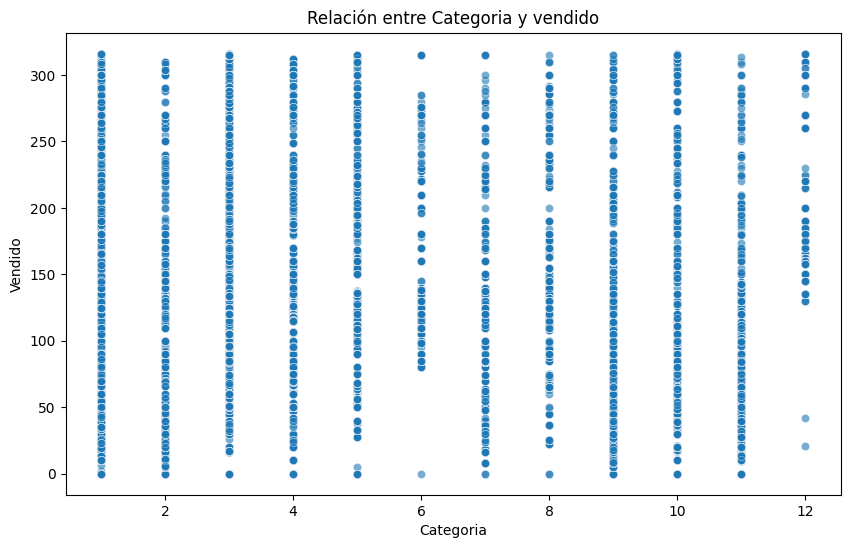

In [125]:
# Gráfico de dispersión (scatter plot)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x="categoria", y="total", alpha=0.6)
plt.title("Relación entre Categoria y vendido")
plt.xlabel("Categoria")
plt.ylabel("Vendido")
plt.show()

In [121]:
# Feature Engineering
def preprocess_data(df):
    # Features temporales
    df['dia_semana'] = df['fecha'].dt.dayofweek
    df['mes'] = df['fecha'].dt.month

    # Lags y rolling means (por categoría)
    df['lag_7d'] = df.groupby('categoria')['total'].shift(7)
    df['rolling_mean_7d'] = df.groupby('categoria')['total'].transform(
        lambda x: x.rolling(7, min_periods=1).mean()
    )

    # One-hot encoding para categorías (XGBoost)
    df = pd.get_dummies(df, columns=['categoria'], prefix='cat')

    # Eliminar filas con nulos (por lags)
    df.dropna(inplace=True)
    return df

df_processed = preprocess_data(df.copy())


In [122]:
# 3. Split temporal (80% train, 20% test)
train = df_processed[df_processed['fecha'] < '2025-02-01']
test = df_processed[df_processed['fecha'] >= '2025-02-01']


XGBoost - MAE: 37.42802655880993
XGBoost - RMSE: 50.6539486465158
XGBoost - R2: 0.3940386217545876


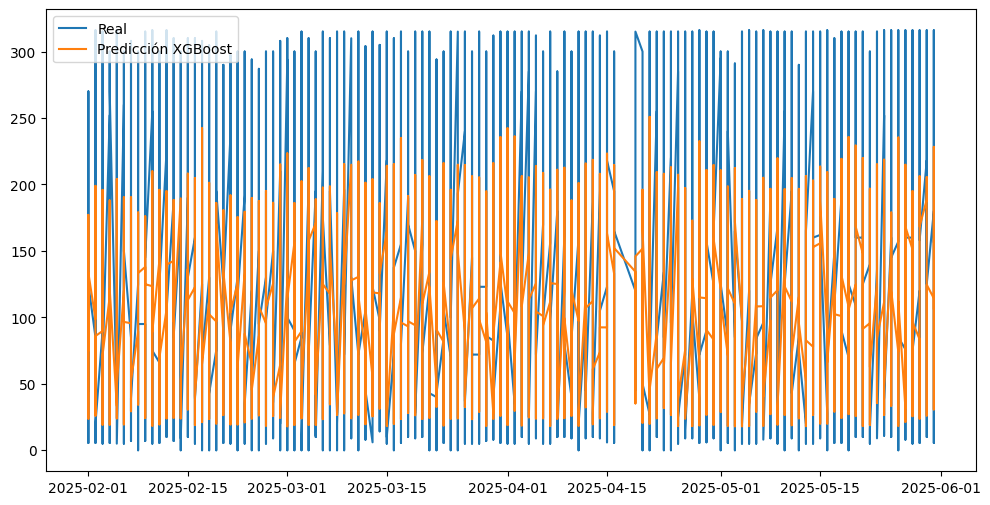

In [123]:
# Features y target
features_xgb = [col for col in train.columns if col not in ['fecha', 'total']]
X_train_xgb, y_train_xgb = train[features_xgb], train['total']
X_test_xgb, y_test_xgb = test[features_xgb], test['total']

# Entrenamiento
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    early_stopping_rounds=50,
    eval_metric='mae'
)
model_xgb.fit(X_train_xgb, y_train_xgb, eval_set=[(X_test_xgb, y_test_xgb)], verbose=False)

# Predicción y evaluación
preds_xgb = model_xgb.predict(X_test_xgb)
print("XGBoost - MAE:", mean_absolute_error(y_test_xgb, preds_xgb))
print("XGBoost - RMSE:", np.sqrt(mean_squared_error(y_test_xgb, preds_xgb)))
print("XGBoost - R2:", r2_score(y_test_xgb, preds_xgb))


# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(test['fecha'], y_test_xgb, label='Real')
plt.plot(test['fecha'], preds_xgb, label='Predicción XGBoost')
plt.legend()
plt.show()

In [126]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 1. Preparar datos para LSTM (usamos misma data preprocesada)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[['total']])
test_scaled = scaler.transform(test[['total']])

# 2. Crear secuencias (ventana de 14 días)
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 14
X_train_lstm, y_train_lstm = create_sequences(train_scaled, window_size)
X_test_lstm, y_test_lstm = create_sequences(test_scaled, window_size)

# 3. Modelo LSTM
model_lstm = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 1)),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')

# 4. Entrenamiento
model_lstm.fit(
    X_train_lstm, y_train_lstm,
    epochs=50,
    batch_size=32,
    validation_data=(X_test_lstm, y_test_lstm),
    verbose=1
)

# 5. Predicción y evaluación
preds_lstm = model_lstm.predict(X_test_lstm)
preds_lstm = scaler.inverse_transform(preds_lstm)
y_test_orig = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))
print("LSTM - MAE:", mean_absolute_error(y_test_orig, preds_lstm))
print("LSTM - RMSE:", np.sqrt(mean_squared_error(y_test_orig, preds_lstm)))
print("LSTM - R2:", r2_score(y_test_orig, preds_lstm))


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2509/2509 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 0.0379 - val_loss: 0.0368
Epoch 2/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0347 - val_loss: 0.0366
Epoch 3/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0352 - val_loss: 0.0364
Epoch 4/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0346 - val_loss: 0.0364
Epoch 5/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 40s 8ms/step - loss: 0.0349 - val_loss: 0.0367
Epoch 6/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0350 - val_loss: 0.0363
Epoch 7/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 0.0350 - val_loss: 0.0364
Epoch 8/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0349 - val_loss: 0.0368
Epoch 9/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0346 - val_loss: 0.0363
Epoch 10/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0352 - val_loss: 0.0364
Epoch 11/50
2509/2509 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0346 - val_loss: 0.0364
Epoch 12/50
2509/2509 ━━━━━━━━

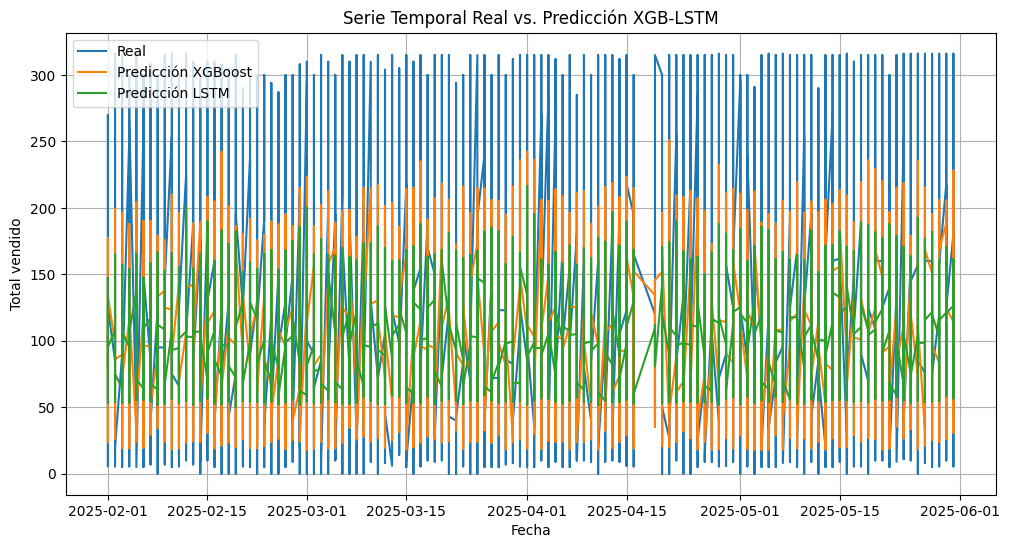

In [129]:

# Graficar resultados LSTM
plt.figure(figsize=(12, 6))
plt.plot(test['fecha'].iloc[window_size:], y_test_orig, label='Real')
plt.plot(test['fecha'], preds_xgb, label='Predicción XGBoost')
plt.plot(test['fecha'].iloc[window_size:], preds_lstm, label='Predicción LSTM')
plt.title('Serie Temporal Real vs. Predicción XGB-LSTM')
plt.xlabel('Fecha')
plt.ylabel('Total vendido')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# prompt: Generar una nueva prediccion con el modelo XGBoost para la fecha 25/06/2025 y la categoria 2

# Preparar los datos para la nueva predicción con XGBoost
# Crear un DataFrame con la fecha y categoría para la predicción
new_date = pd.to_datetime('2025-06-25')
new_category = 2

# Crear un DataFrame de una fila con la fecha y categoría deseadas
new_data = pd.DataFrame({'fecha': [new_date], 'categoria': [new_category]})

# Replicar la estructura de las features después del preprocesamiento para XGBoost
# Asegurarse de tener todas las columnas de dummy variables de categoría
# Primero, obtener las columnas de dummy variables del DataFrame entrenado
cat_cols = [col for col in df_processed.columns if col.startswith('cat_')]
# Asegurarse de que el nuevo DataFrame tenga todas esas columnas, inicializadas a 0
for cat_col in cat_cols:
    new_data[cat_col] = 0

# Establecer la columna correspondiente a la nueva categoría a 1
new_data[f'cat_{new_category}'] = 1

# Añadir las features temporales
new_data['dia_semana'] = new_data['fecha'].dt.dayofweek
new_data['mes'] = new_data['fecha'].dt.month

# Para los lags y rolling means, necesitamos datos históricos relevantes.
# Para una predicción puntual en el futuro, es difícil obtener los valores 'reales'
# de los lags y rolling means en ese momento exacto.
# Una estrategia común es usar los últimos valores disponibles en los datos de entrenamiento/test
# como proxy, o intentar simular esos valores si es posible.
# Aquí, por simplicidad, vamos a llenar los lags y rolling means con un valor plausible
# (por ejemplo, el último valor conocido del rolling mean para esa categoría, o el promedio general).
# Un enfoque más robusto requeriría una generación de features más compleja para fechas futuras.

# Para este ejemplo, vamos a llenar con el promedio del rolling mean en el conjunto de entrenamiento
# para la categoría específica si está disponible, o el promedio general si no.
avg_rolling_mean = train[train[f'cat_{new_category}'] == 1]['rolling_mean_7d'].mean()
if pd.isna(avg_rolling_mean):
    avg_rolling_mean = train['rolling_mean_7d'].mean() # Fallback al promedio general
new_data['rolling_mean_7d'] = avg_rolling_mean

# Para el lag_7d, necesitamos el valor de 'total' 7 días antes del 25/06/2025 para la categoría 2.
# Como no tenemos ese dato real, una aproximación podría ser usar la última observación disponible
# para esa categoría, o una predicción anterior si tuviéramos un modelo iterativo.
# Para simplificar, usaremos el último valor de 'total' conocido para la categoría 2 en los datos de test.
last_known_total_cat2 = test[test[f'cat_{new_category}'] == 1]['total'].iloc[-1] if not test[test[f'cat_{new_category}'] == 1]['total'].empty else train[train[f'cat_{new_category}'] == 1]['total'].iloc[-1] # Fallback a train
new_data['lag_7d'] = last_known_total_cat2 # Esto es una aproximación, no el valor real.

# Asegurarse de que el nuevo DataFrame tiene exactamente las mismas columnas que X_train_xgb
# en el mismo orden.
X_new = new_data[features_xgb]

# Generar la predicción con el modelo XGBoost
new_prediction_xgb = model_xgb.predict(X_new)

print(f"Predicción de ventas para el {new_date.date()} y categoría {new_category} (XGBoost): {new_prediction_xgb[0]:.2f}")

In [ ]:
# prompt: Genera una nueva prediccion para el modelo LSTM

# Preparar los datos para la nueva predicción con LSTM
# NOTA: La predicción con LSTM requiere secuencias de datos pasados (ventana).
# Para predecir una única fecha futura, necesitamos una ventana de `window_size`
# días *antes* de esa fecha objetivo para la categoría específica.
# Esto presenta un desafío similar al de los lags en XGBoost: necesitamos datos históricos reales.
# Si queremos predecir solo la *próxima* observación después del conjunto de test,
# podemos usar la última `window_size` observaciones del conjunto de test.
# Si queremos predecir una fecha más lejana, esto se vuelve más complejo
# (se necesita una estrategia iterativa o usar datos simulados/predichos para la ventana).

# Para demostrar una predicción simple con LSTM para la *siguiente* fecha después
# del conjunto de test (asumiendo que es la fecha 2025-06-25 para la categoría 2),
# usaremos la última ventana disponible en el conjunto de test *para esa categoría*.

# Filtrar el conjunto de test para la categoría específica y tomar la última ventana
test_cat_2 = test[test['cat_2'] == 1].copy()

if len(test_cat_2) >= window_size:
    # Tomar las últimas 'window_size' observaciones de 'total' para la categoría 2
    # y escalarlas
    last_window_cat_2 = test_cat_2['total'].values[-window_size:].reshape(-1, 1)
    last_window_scaled_cat_2 = scaler.transform(last_window_cat_2)

    # Reformar para que coincida con el input del LSTM (samples, timesteps, features)
    X_predict_lstm = last_window_scaled_cat_2.reshape(1, window_size, 1)

    # Generar la predicción con el modelo LSTM
    new_prediction_lstm_scaled = model_lstm.predict(X_predict_lstm)

    # Invertir la escala de la predicción
    new_prediction_lstm = scaler.inverse_transform(new_prediction_lstm_scaled)

    print(f"Predicción de ventas para la siguiente fecha después del test para categoría {new_category} (LSTM): {new_prediction_lstm[0][0]:.2f}")
else:
    print(f"No hay suficientes datos (al menos {window_size} días) en el conjunto de test para la categoría {new_category} para crear una ventana para la predicción LSTM.")

# Si deseas predecir una fecha específica más lejana con LSTM, necesitarías
# un enfoque diferente, como predecir de forma secuencial (prediciendo un día,
# añadiéndolo a la ventana y prediciendo el siguiente) o usar otras técnicas.
# El código anterior asume la predicción del *siguiente* paso en la serie temporal
# para la categoría 2 usando la última ventana disponible.